In [63]:
# 1. Imports & Configuration
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import acf
from scipy.signal import periodogram
from scipy.stats import ks_2samp
from sklearn.metrics import pairwise_distances, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import euclidean
from IPython.display import display

In [64]:
# Reproducible seed
np.random.seed(42)

In [65]:
# 2. Load & Preprocess Data
# -------------------------
csv_path = './data/weather/temp.csv'

df = pd.read_csv(csv_path)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Extract real series
y = df['T (degC)'].values
n = len(y)
t = np.arange(n)

print("Real data (first 10 rows):")
print(df.head(10))

/var/folders/kw/zxdjxts97j33lc5_j5mmjgtm0000gn/T/ipykernel_1321/4092024188.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])


Real data (first 10 rows):
                     T (degC)
date                         
2020-01-01 00:10:00      0.71
2020-01-01 00:20:00      0.75
2020-01-01 00:30:00      0.73
2020-01-01 00:40:00      0.37
2020-01-01 00:50:00      0.33
2020-01-01 01:00:00      0.34
2020-01-01 01:10:00      0.19
2020-01-01 01:20:00      0.03
2020-01-01 01:30:00      0.11
2020-01-01 01:40:00      0.22


In [66]:
# 3. Parameter Estimation: Trend & Seasonality
# -------------------------------------------
# 3.1 Linear trend: y_t = beta * t + c
beta, c = np.polyfit(t, y, 1)
trend = beta * t + c

# 3.2 Seasonal components: daily + annual sinusoids
T_daily = 144  # 24h * 6 samples/hour
T_annual = 365 * T_daily  # one full year
# Construct four regressors: sin & cos for each cycle
X_season = np.column_stack([
    np.sin(2 * np.pi * t / T_daily),
    np.cos(2 * np.pi * t / T_daily),
    np.sin(2 * np.pi * t / T_annual),
    np.cos(2 * np.pi * t / T_annual)
])
resid_trend = y - trend
# Least squares fit for both cycles
alpha, *_ = np.linalg.lstsq(X_season, resid_trend, rcond=None)
# Extract amplitudes and phases
A_daily = np.hypot(alpha[0], alpha[1])
phi_daily = np.arctan2(alpha[1], alpha[0])
A_annual = np.hypot(alpha[2], alpha[3])
phi_annual = np.arctan2(alpha[3], alpha[2])
# Reconstruct seasonal components
season_daily = A_daily * np.sin(2 * np.pi * t / T_daily + phi_daily)
season_annual = A_annual * np.sin(2 * np.pi * t / T_annual + phi_annual)
seasonal = season_daily + season_annual

Real vs. Synthetic (first 10 rows):


,Real,Synthetic
date,,
2020-01-01 00:10:00,0.71,0.710000
2020-01-01 00:20:00,0.75,0.750000
2020-01-01 00:30:00,0.73,0.730000
2020-01-01 00:40:00,0.37,0.370000
2020-01-01 00:50:00,0.33,0.330000
2020-01-01 01:00:00,0.34,0.267066
2020-01-01 01:10:00,0.19,0.493361
2020-01-01 01:20:00,0.03,0.711263
2020-01-01 01:30:00,0.11,0.663036


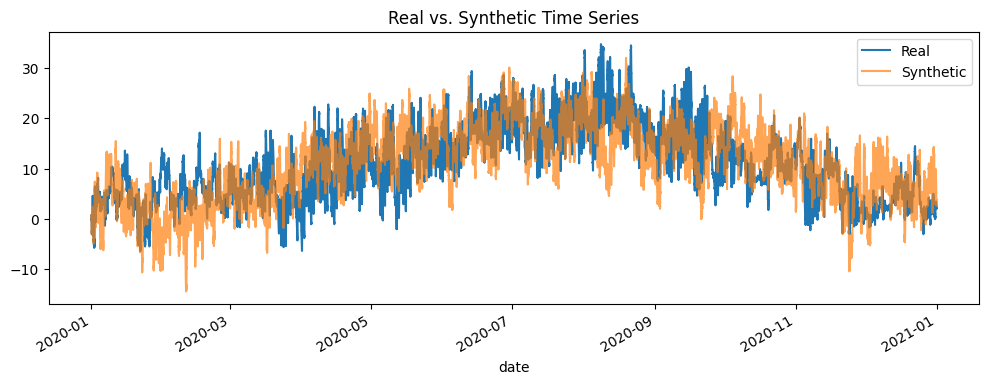

In [67]:
# 4. AR Residual Modeling & Synthetic Generation
# --------------------------------------------
residuals = y - trend - seasonal
p = 5  # AR order
ar = AutoReg(residuals, lags=p, old_names=False).fit()
phi = ar.params[1:]
sigma = np.sqrt(ar.sigma2)

# Simulate synthetic residuals
epsilon = np.random.normal(0, sigma, size=n)
syn_resid = np.zeros(n)
syn_resid[:p] = residuals[:p]  # warm start
for i in range(p, n):
    syn_resid[i] = (phi @ syn_resid[i-p:i][::-1]) + epsilon[i]

synthetic = trend + seasonal + syn_resid

# Wrap into pandas Series
series_real = pd.Series(y, index=df.index, name='Real')
series_syn = pd.Series(synthetic, index=df.index, name='Synthetic')

# Compare first 10 rows
compare = pd.concat([series_real, series_syn], axis=1)
print("Real vs. Synthetic (first 10 rows):")
display(compare.head(10))

# Optional plot of comparison
plt.figure(figsize=(12, 4))
series_real.plot(label='Real')
series_syn.plot(label='Synthetic', alpha=0.7)
plt.legend(); plt.title('Real vs. Synthetic Time Series'); plt.show()

In [68]:
# 5. Metric Computations
# ----------------------
metrics = {}

In [69]:
# 5.1 Mean & Variance Differences
df_marg = pd.DataFrame({
    'Real': [series_real.mean(), series_real.var()],
    'Synthetic': [series_syn.mean(), series_syn.var()]
}, index=['Mean', 'Variance'])
print("Mean & Variance Comparison:")
display(df_marg)
metrics['Mean Diff'] = series_real.mean() - series_syn.mean()
metrics['Var Diff'] = series_real.var() - series_syn.var()

Mean & Variance Comparison:


,Real,Synthetic
Mean,10.818241,10.788839
Variance,55.781040,54.707698


In [70]:
# 5.2 ACF distance
def acf_l2(x, y, nlags=30):
    ax = acf(x, nlags=nlags, fft=True)
    ay = acf(y, nlags=nlags, fft=True)
    return np.sum((ax - ay)**2)
metrics['ACF L2 Dist'] = acf_l2(series_real, series_syn)
print(f"ACF L2 Distance (lags 0–30): {metrics['ACF L2 Dist']:.4f}")

ACF L2 Distance (lags 0–30): 0.0036


In [71]:
# 5.3 PSD distance
def psd_l2(x, y):
    fx, Px = periodogram(x)
    fy, Py = periodogram(y)
    return np.sum((Px - Py)**2)
metrics['PSD L2 Dist'] = psd_l2(series_real, series_syn)
print(f"PSD L2 Distance: {metrics['PSD L2 Dist']:.4f}")

PSD L2 Distance: 41037759764.8354


In [72]:
# 5.4 KS test
ksd, ksp = ks_2samp(series_real, series_syn)
metrics['KS Statistic'] = ksd
metrics['KS p-value'] = ksp
print(f"KS Statistic D: {ksd:.4f}, p-value: {ksp:.4f}")

KS Statistic D: 0.0453, p-value: 0.0000


In [73]:
# 5.5 MMD (subsample)
def mmd_sub(x, y, m=500):
    ix = np.random.choice(len(x), m, replace=False)
    iy = np.random.choice(len(y), m, replace=False)
    Xs, Ys = x[ix].reshape(-1,1), y[iy].reshape(-1,1)
    Z = np.vstack([Xs, Ys])
    sig = np.median(pairwise_distances(Z, metric='euclidean'))
    Kxx = np.exp(-pairwise_distances(Xs, Xs, squared=True)/(2*sig**2))
    Kyy = np.exp(-pairwise_distances(Ys, Ys, squared=True)/(2*sig**2))
    Kxy = np.exp(-pairwise_distances(Xs, Ys, squared=True)/(2*sig**2))
    m, n_ = len(Xs), len(Ys)
    return ((Kxx.sum()-np.trace(Kxx))/(m*(m-1))
          +(Kyy.sum()-np.trace(Kyy))/(n_*(n_-1))
          -2*Kxy.sum()/(m*n_))
metrics['MMD'] = mmd_sub(series_real.values, series_syn.values)
print(f"MMD: {metrics['MMD']:.6f}")

MMD: -0.000292


In [74]:
# 5.6 DTW (segment avg)
def dtw(x, y):
    nx, ny = len(x), len(y)
    D = np.full((nx+1, ny+1), np.inf)
    D[0,0] = 0
    for i in range(1, nx+1):
        for j in range(1, ny+1):
            cost = abs(x[i-1] - y[j-1])
            D[i,j] = cost + min(D[i-1,j], D[i,j-1], D[i-1,j-1])
    return D[nx, ny]
segs, L = 5, 1000
dvals = []
for _ in range(segs):
    s = np.random.randint(0, n-L)
    dvals.append(dtw(y[s:s+L], synthetic[s:s+L]))
metrics['DTW Dist (avg)'] = np.mean(dvals)
print(f"Avg DTW over {segs} segments: {metrics['DTW Dist (avg)']:.4f}")

Avg DTW over 5 segments: 2282.8122


In [75]:
# 5.7 Classifier accuracy
w = 50
X, yl = [], []
for i in range(n-w):
    X.append(y[i:i+w]);    yl.append(0)
    X.append(synthetic[i:i+w]); yl.append(1)
X = np.array(X).reshape(-1, w)
yl = np.array(yl)
Xtr, Xte, ytr, yte = train_test_split(X, yl, test_size=0.3, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42).fit(Xtr, ytr)
metrics['Classifier Acc'] = accuracy_score(yte, clf.predict(Xte))
print(f"Classifier Accuracy: {metrics['Classifier Acc']:.4f}")

Classifier Accuracy: 0.9048


In [76]:
# 6. Summary of All Metrics
results = pd.Series(metrics).to_frame('Value')
print("\nOverall Metrics Summary:")
display(results)


Overall Metrics Summary:


,Value
Mean Diff,2.940165e-02
Var Diff,1.073342e+00
ACF L2 Dist,3.590687e-03
PSD L2 Dist,4.103776e+10
KS Statistic,4.531653e-02
KS p-value,1.858948e-47
MMD,-2.919167e-04
DTW Dist (avg),2.282812e+03
Classifier Acc,9.048056e-01
